In [1]:
root_dir = "../../Downloads/GENOME540/"
read_count_path = root_dir + "chm13.chr16.txt"

In [2]:
import numpy as np

def read_rc(filename):
    return np.loadtxt(filename, usecols=(2,))

true_read_count = read_rc(read_count_path)
true_read_count = np.array([3 if x > 3 else x for x in true_read_count], dtype="int16")

In [3]:
score_scheme, D, S = {0: -0.1077, 1: 0.4772, 2: 1.0622, 3: 1.6748}, -20.0, 20.0   # from hw 6

def find_dsegs(read_counts, scoring_scheme, d, s):

    scorez = [scoring_scheme[n] for n in read_counts]

    cumulative = maximum = start = 0
    for i in range(len(scorez)):
        cumulative += scorez[i]
        if cumulative >= maximum:
            maximum = cumulative
            end = i
        if cumulative <= 0 or cumulative <= maximum + d or i == len(scorez)-1:
            if maximum >= s:
                yield start, end, maximum
            cumulative = maximum = 0
            start = end = i + 1

elevated = list(find_dsegs(true_read_count, score_scheme, D, S))

In [4]:
N_CORRECTION = 8422401 # number of Ns in chr16

def calc_y_0(read_counts):

    chrom_size = read_counts.shape[0]
    adj_chrom_size = chrom_size - N_CORRECTION

    _, counts = np.unique(np.sort(read_counts)[N_CORRECTION:], return_counts=True)
    return counts / adj_chrom_size

back_freq = calc_y_0(true_read_count)

In [5]:
def calc_y_1(read_counts, elev):

    elev_size = 0
    y_1 = np.arange(4)
    for elevated_seq in elev:
        elev_seq = read_counts[elevated_seq[0]: elevated_seq[1]]
        y_1 += np.bincount(elev_seq, minlength=4)
        elev_size += elev_seq.shape[0]

    return y_1 / elev_size

elev_freq = calc_y_1(true_read_count, elevated)

In [6]:
def create_scoring_scheme(y_0, y_1):

    weights = np.log2(y_1 / y_0)
    scoring_scheme = dict(zip([0,1,2,3], weights))

    return scoring_scheme

new_score_scheme = create_scoring_scheme(back_freq, elev_freq)
new_score_scheme

{0: -0.21493818245357393,
 1: 0.7374806665383026,
 2: 1.7410234387472736,
 3: 4.64836450998296}

In [7]:
print("Background frequencies:")
print(f"0={back_freq[0]:.4f}")
print(f"1={back_freq[1]:.4f}")
print(f"2={back_freq[2]:.4f}")
print(f">=3={back_freq[3]:.4f}")

print("\nTarget frequencies:")
print(f"0={elev_freq[0]:.4f}")
print(f"1={elev_freq[1]:.4f}")
print(f"2={elev_freq[2]:.4f}")
print(f">=3={elev_freq[3]:.4f}")

print("\nScoring scheme:")
print(f"0={new_score_scheme[0]:.4f}")
print(f"1={new_score_scheme[1]:.4f}")
print(f"2={new_score_scheme[2]:.4f}")
print(f">=3={new_score_scheme[3]:.4f}")

Background frequencies:
0=0.8773
1=0.1126
2=0.0090
>=3=0.0010

Target frequencies:
0=0.7559
1=0.1878
2=0.0300
>=3=0.0263

Scoring scheme:
0=-0.2149
1=0.7375
2=1.7410
>=3=4.6484


In [8]:
sim_read_count = np.digitize(np.random.random(size=len(true_read_count) - N_CORRECTION), np.cumsum(back_freq))

In [9]:
D, S = -5.0, 5.0
true_dsegs = list(find_dsegs(true_read_count, new_score_scheme, D, S))
sim_dsegs = list(find_dsegs(sim_read_count, new_score_scheme, D, S))

In [10]:
def count_by_score(arr, score):
    return sum(1 for _, _, s in arr if s >= score)

def display_dseg_stats(dsegs1, dsegs2):

    print("Real data:")
    for s in range(5, 31):
        print(s, count_by_score(dsegs1, s))

    print("\nSimulated data:")
    for s in range(5, 31):
        print(s, count_by_score(dsegs2, s))

    print("\nRatios of real data:")
    for s in range(5, 30):
        denom = count_by_score(dsegs1, s+1)
        if denom == 0:
            ratio = -1
        else:
            ratio = count_by_score(dsegs1, s) / denom

        print(f"N_seg({s})/N_seg({s+1}) {ratio:.2f}")

    print("\nRatios of simulated data:")
    for s in range(5, 30):
        denom = count_by_score(dsegs2, s+1)
        if denom == 0:
            ratio = -1
        else:
            ratio = count_by_score(dsegs2, s) / denom

        print(f"N_seg({s})/N_seg({s+1}) {ratio:.2f}")

display_dseg_stats(true_dsegs, sim_dsegs)

Real data:
5 71010
6 39190
7 22407
8 13844
9 9210
10 6542
11 4935
12 3952
13 3326
14 2852
15 2508
16 2234
17 2065
18 1895
19 1746
20 1619
21 1536
22 1456
23 1372
24 1306
25 1236
26 1176
27 1127
28 1083
29 1024
30 984

Simulated data:
5 79588
6 38909
7 18421
8 9106
9 4655
10 2337
11 1136
12 548
13 266
14 136
15 65
16 32
17 17
18 9
19 6
20 2
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0

Ratios of real data:
N_seg(5)/N_seg(6) 1.81
N_seg(6)/N_seg(7) 1.75
N_seg(7)/N_seg(8) 1.62
N_seg(8)/N_seg(9) 1.50
N_seg(9)/N_seg(10) 1.41
N_seg(10)/N_seg(11) 1.33
N_seg(11)/N_seg(12) 1.25
N_seg(12)/N_seg(13) 1.19
N_seg(13)/N_seg(14) 1.17
N_seg(14)/N_seg(15) 1.14
N_seg(15)/N_seg(16) 1.12
N_seg(16)/N_seg(17) 1.08
N_seg(17)/N_seg(18) 1.09
N_seg(18)/N_seg(19) 1.09
N_seg(19)/N_seg(20) 1.08
N_seg(20)/N_seg(21) 1.05
N_seg(21)/N_seg(22) 1.05
N_seg(22)/N_seg(23) 1.06
N_seg(23)/N_seg(24) 1.05
N_seg(24)/N_seg(25) 1.06
N_seg(25)/N_seg(26) 1.05
N_seg(26)/N_seg(27) 1.04
N_seg(27)/N_seg(28) 1.04
N_seg(28)/N_seg(29) 

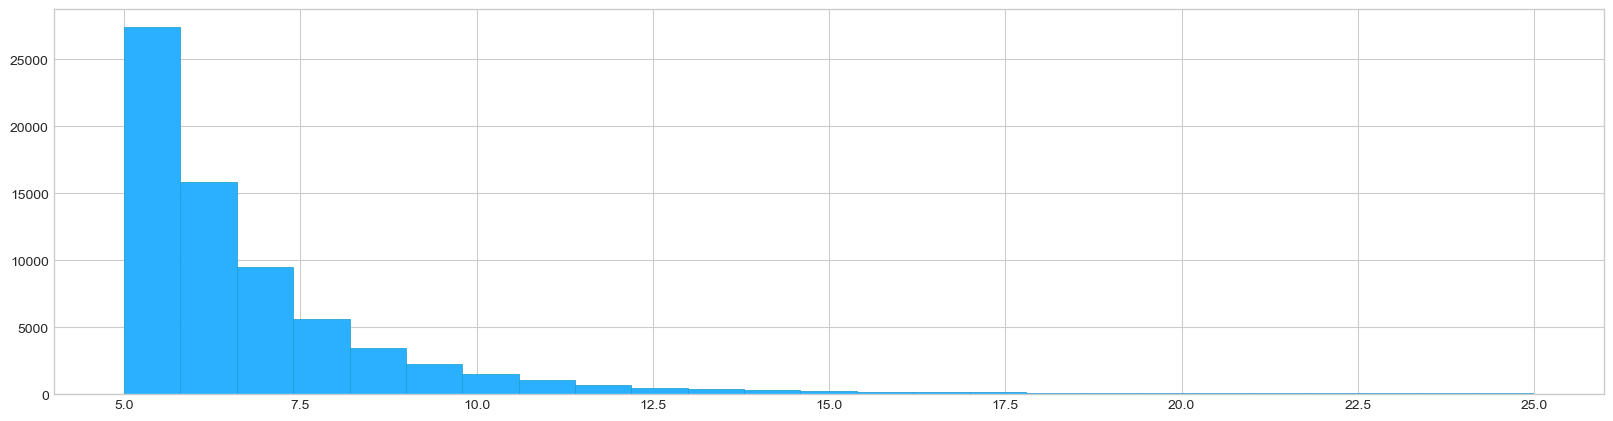

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.hist([x[-1] for x in true_dsegs if x[-1]<=25], bins=25, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()

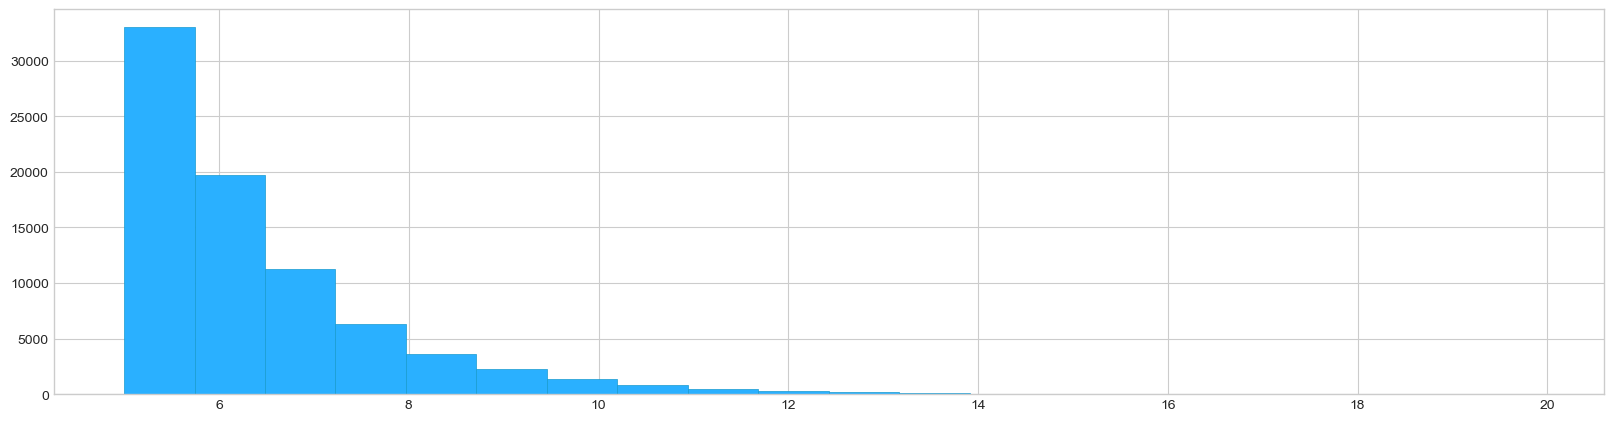

In [20]:
plt.figure(figsize=(20, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.hist([x[-1] for x in sim_dsegs if x[-1]<=20], bins=20, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.show()